# Panoramic view with Stable Diffusion In-painting
> Learn how to use the diffusers library from Hugging Face to generate Panoramic views using In-painting pipeline

- toc: false
- badges: true
- comments: true
- author: dzlab
- categories: [pytorch, vision, diffusion]

In a [previous article](https://dzlab.github.io/notebooks/pytorch/vision/diffusion/2022/12/31/Stable_Diffusion_In_painting.html), we saw how to use the **Text In-painting** pipeline to edit images by locating and replacing objects using their text description. In this article, we will use the simple **In-painting** pipeline to create panormic views. The process is as follows:
- First, we generate few images from our prompt
- Second, we concatenate slices of each adjacent image
- Then, we pass these slices to in-painting pipeline to smooth the concatenation
- Finally, we plot everything in the output image 

## Setup

First, we need to install the dependencies.

In [1]:
%%capture
%%bash

pip install --upgrade accelerate diffusers transformers

Second, accept the term of Stable Diffusion model to be able to download it form Hugging Face.

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


Import needed modules

In [1]:
import random
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionInpaintPipeline

Set seed for reproducibility

In [2]:
random.seed(123)
np.random.seed(123)

## Base images

You can use your own images, or why not use Stable Diffusion to generate them. Let's download the weights of [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4).

In [28]:
generate = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", 
    use_auth_token=True,
    torch_dtype=torch.float16, 
    revision="fp16",
).to('cuda')

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

To avoid out of memory issues, we use half precision and attention slicing which both are supposed to reduce the amout of memory needed by the pipeline.

In [29]:
generate.enable_attention_slicing()

In [30]:
# Parameters
num_images = 6
base_width = 768
base_height = 512
num_steps = 50

Pick a random prompt of your choice

In [37]:
prompt = 'Rocky Mountain High; landscape, natural beauty, deep shadows'

It is usually hard to get the prompt right from the first try, so we need to generate one image first to check if it matches the kind of landscape we want to work on.

In [38]:
img = generate(
    prompt=prompt,
    num_inference_steps=num_steps,
    width=base_width,
    height=base_height,
    ).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

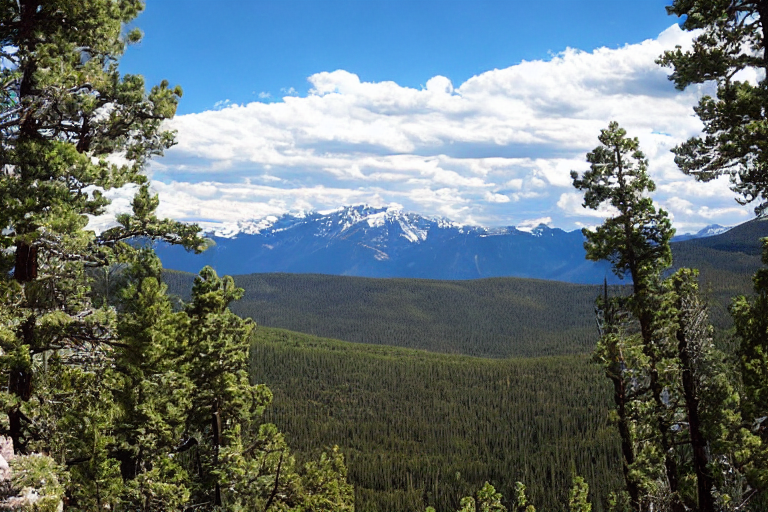

In [39]:
img

For simplicity, we will generate images for our single prompt. But for better results, you may want use as much prompts as the number of output images and check each one of them so that the resulting panorama view will be coherent. 

In [40]:
prompts = [prompt] * num_images

In [41]:
imgs = generate(
    prompt=prompts,
    num_inference_steps=num_steps,
    width=base_width,
    height=base_height,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

To save on GPU memory, we remove the Stable Diffusion pipeline from GPU as we won't be using it later.

In [42]:
del generate
torch.cuda.empty_cache()

Let's plot a sample of the images we generated in the previous step

In [43]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

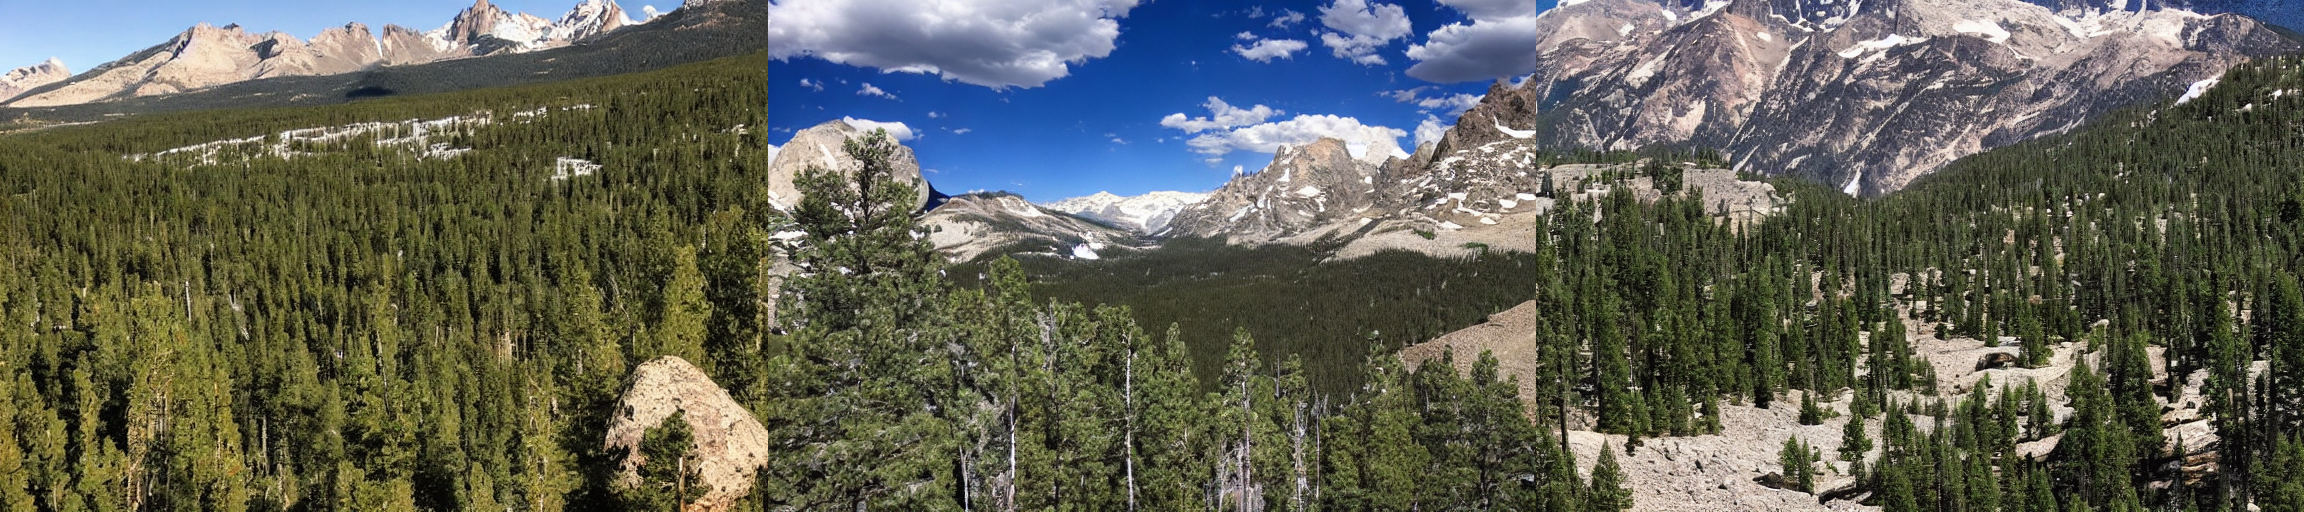

In [44]:
image_grid(random.sample(imgs, 3), 1, 3)

Because we used the same prompt to generate our images they seem very unlikely to be part of same view. For instance, look at the differences in the color of the sky in each of those images.

You may want use individual prompts and inspect the resulting images individually before proceeding to next step.

## Panoramic view

The image input to the in-painting pipeline is created by concatenating adjacent images. The following helper functions takes half of the left image and concatenate it with half of the right image.

In [45]:
def create_input_image(left, right):
    w,h = left.size
    new = Image.new('RGB', (base_width, base_height))
    new.paste(left, (-w+base_width//2, 0))
    new.paste(right, (base_width//2, 0))
    return new

Let's plot the output of the previous function to better understand what it does

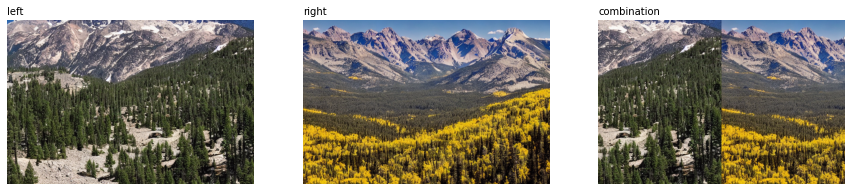

In [46]:
_, ax = plt.subplots(1, 3, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
images = [imgs[0], imgs[1], create_input_image(imgs[0], imgs[1])]
[ax[i].imshow(images[i]) for i in range(3)];
titles = ["left", "right", "combination"]
[ax[i].text(0, -15, titles[i]) for i in range(3)];

The in-painting pipeline needs a mask that can be used to paint over and generate an image matching the prompt. The following helper function creates a mask where the edges are preserved. The model will need to paint the area in the middle to make the transition from the left to the right smooth. 

In [47]:
def create_mask(width, height):
    msk = Image.new('L', (width, height))
    drw = ImageDraw.Draw(msk)
    drw.rectangle((width//4, 0, 3*width//4, height), fill=255)
    return msk

In [ ]:
msk = create_mask(base_width, base_height)

This is what the mask looks like

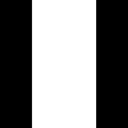

In [48]:
msk.resize((128, 128))

The following helper function concatenates the different parts to create a resulting image.
> Note: The middle image will be generated by the in-painting pipeline

In [49]:
def create_output_image(left, middle, right):
    w,h = left.size
    new = Image.new('RGB', (w+base_width, base_height))
    new.paste(left, (0, 0))
    new.paste(middle, (w-base_width//2, 0))
    img = right.crop((base_width//2, 0, base_width, base_height))
    new.paste(img, (w+base_width//2, 0))
    return new

Let's visualize the result of the previous function to have a sense of what it does.

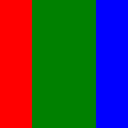

In [50]:
left = Image.new(mode="RGB", size=(base_width,base_height), color="red")
middle = Image.new(mode="RGB", size=(base_width,base_height), color="green")
right = Image.new(mode="RGB", size=(base_width,base_height), color="blue")
create_output_image(left, middle, right).resize((128, 128))

Now we can create the in-painting pipeline by downloading the weights from [runwayml/stable-diffusion-inpainting](https://huggingface.co/runwayml/stable-diffusion-inpainting).

In [51]:
inpaint = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16, 
    revision="fp16",
).to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

> Note: Same as before to avoid OOM, we use half precision and attention slicing

In [52]:
inpaint.enable_attention_slicing()

Finally, we put everything together to generate the panormic view by:
- Combining each of the previous image and
- Leveraging in-painting pipeline to smooth the concatenation of adjacent images.

In [53]:
prev = imgs[0]

for curr in tqdm(imgs[1:] + [imgs[0]]):
    new = create_input_image(prev, curr)

    merged = inpaint(
        prompt=prompt,
        image=new,
        mask_image=msk,
        height=base_height,
        width=base_width,
        num_inference_steps=num_steps,
        ).images[0]

    prev = create_output_image(prev, merged, curr)

w, h = prev.size
output = prev.crop((base_width//2, 0, w-base_width//2, h))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [54]:
del inpaint
torch.cuda.empty_cache()

Save the resulting image and upload to this [panorama web viewer](https://renderstuff.com/tools/360-panorama-web-viewer/) for better visualization.

In [55]:
panorama = Image.new('RGB', (w, 3*h))
panorama.paste(output, (0, h))
panorama.size

(5376, 1536)

In [56]:
panorama.save('panorama.jpeg')

## That's all folks
In this article, we saw how Stable Diffusion can be used to create panoamic views by generating few random images then using in-paiting to merge them smoothly. 

I hope you enjoyed this article, feel free to leave a comment or reach out on twitter [@bachiirc](https://twitter.com/bachiirc).